In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.tsa.stattools import adfuller, kpss
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pulling in data

In [ ]:
combined = pd.read_csv('/content/drive/My Drive/DS4A/my_data_file.csv',parse_dates=['date'], index_col='date')

In [ ]:
combined.head()

,county,precip_mm,temp_min_celsius,temp_mean_celsius,temp_max_celsius,case_count,longitude_west,latitude_north,region,month,season,Year,Population,cases_per_100k
date,,,,,,,,,,,,,,
2006-01-07,Alameda,9.561429,5.457143,10.342857,15.228571,0,122,37,3,1,1,2006,1462371,0.0
2006-01-14,Alameda,1.148571,3.728571,9.557143,15.385714,0,122,37,3,1,1,2006,1462371,0.0
2006-01-21,Alameda,3.211429,2.857143,8.000000,13.114286,0,122,37,3,1,1,2006,1462371,0.0
2006-01-28,Alameda,0.437143,3.257143,8.657143,14.100000,0,122,37,3,1,1,2006,1462371,0.0
2006-02-04,Alameda,2.841429,6.414286,11.185714,15.928571,0,122,37,3,2,1,2006,1462371,0.0


In [ ]:
df=combined.copy()

Additional EDA for model specifications

In [ ]:
df_county=df.drop(['temp_min_celsius','temp_mean_celsius','precip_mm','temp_max_celsius','longitude_west','latitude_north','region','season','month'],axis=1)
df_year=df.drop(['temp_min_celsius','temp_mean_celsius','precip_mm','temp_max_celsius','longitude_west','latitude_north','region','season','month'],axis=1)
df_month=df.drop(['temp_min_celsius','temp_mean_celsius','precip_mm','temp_max_celsius','longitude_west','latitude_north','region','season'],axis=1)

In [ ]:
df_county.reset_index(inplace=True)
df_year.reset_index(inplace=True)
df_month.reset_index(inplace=True)

In [ ]:
df.head()

,county,precip_mm,temp_min_celsius,temp_mean_celsius,temp_max_celsius,case_count,longitude_west,latitude_north,region,month,season,Year,Population,cases_per_100k
date,,,,,,,,,,,,,,
2006-01-07,Alameda,9.561429,5.457143,10.342857,15.228571,0,122,37,3,1,1,2006,1462371,0.0
2006-01-14,Alameda,1.148571,3.728571,9.557143,15.385714,0,122,37,3,1,1,2006,1462371,0.0
2006-01-21,Alameda,3.211429,2.857143,8.000000,13.114286,0,122,37,3,1,1,2006,1462371,0.0
2006-01-28,Alameda,0.437143,3.257143,8.657143,14.100000,0,122,37,3,1,1,2006,1462371,0.0
2006-02-04,Alameda,2.841429,6.414286,11.185714,15.928571,0,122,37,3,2,1,2006,1462371,0.0


In [ ]:
df_county=df_county.groupby(['county'])['case_count'].sum()
df_year=df_year.groupby(['Year'])['case_count'].sum()
df_month=df_month.groupby(['month'])['case_count'].sum()

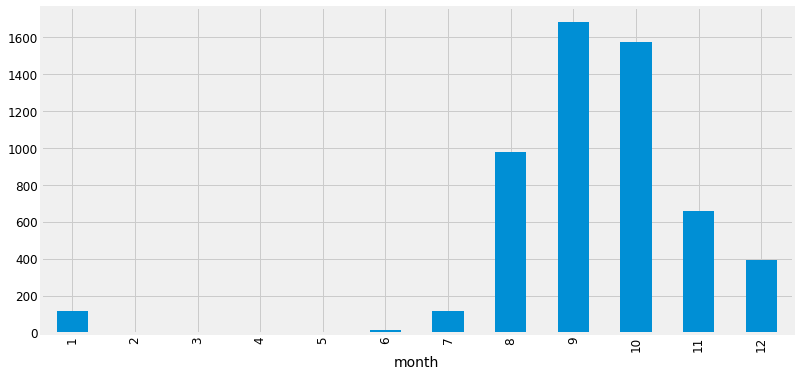

In [ ]:
df_month.plot(kind='bar', figsize=(12,6))

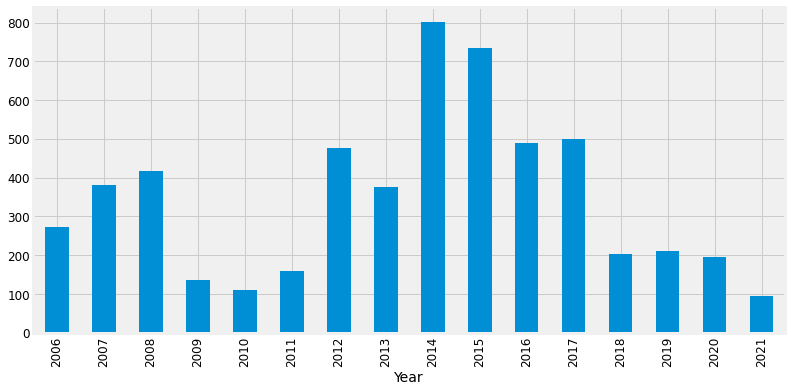

In [ ]:
df_year.plot(kind='bar', figsize=(12,6))

In [ ]:
df_county=df_county.sort_values(ascending=False)

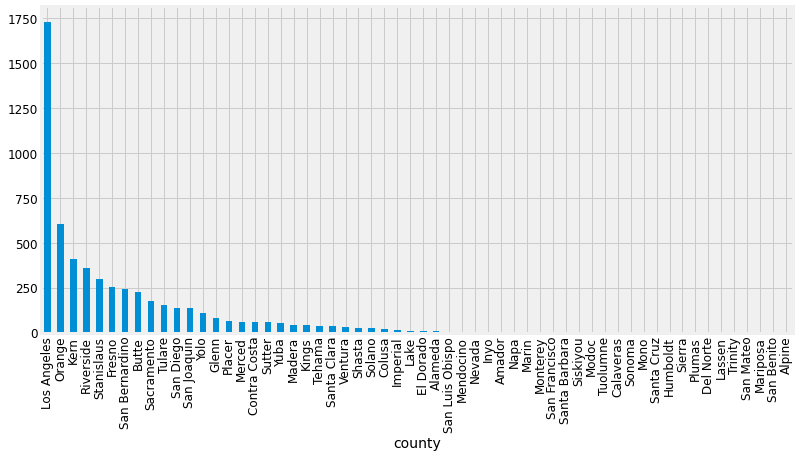

In [ ]:
df_county.plot(kind='bar', figsize=(12,6))

Segmenting Data and Preparing for Analysis

In [ ]:
df_county.head(20)

county
Los Angeles       1730
Orange             603
Kern               409
Riverside          362
Stanislaus         298
Fresno             254
San Bernardino     245
Butte              225
Sacramento         176
Tulare             156
San Diego          135
San Joaquin        134
Yolo               107
Glenn               79
Placer              66
Merced              60
Contra Costa        59
Sutter              59
Yuba                52
Madera              44
Name: case_count, dtype: int64

In [ ]:
df_county.head(25)

county
Los Angeles       1730
Orange             603
Kern               409
Riverside          362
Stanislaus         298
Fresno             254
San Bernardino     245
Butte              225
Sacramento         176
Tulare             156
San Diego          135
San Joaquin        134
Yolo               107
Glenn               79
Placer              66
Merced              60
Contra Costa        59
Sutter              59
Yuba                52
Madera              44
Kings               41
Tehama              38
Santa Clara         34
Ventura             32
Shasta              27
Name: case_count, dtype: int64

In [ ]:
df_county=df_county.to_frame()

In [ ]:
df_county = df_county[(df_county['case_count']>40)].reset_index()

In [ ]:
counties = df_county['county'].tolist()

In [ ]:
counties

['Los Angeles',
 'Orange',
 'Kern',
 'Riverside',
 'Stanislaus',
 'Fresno',
 'San Bernardino',
 'Butte',
 'Sacramento',
 'Tulare',
 'San Diego',
 'San Joaquin',
 'Yolo',
 'Glenn',
 'Placer',
 'Merced',
 'Contra Costa',
 'Sutter',
 'Yuba',
 'Madera',
 'Kings']

In [ ]:
df_top20=df[(df['county'].isin(counties))]

In [ ]:
df=df.drop(['county','temp_min_celsius','temp_max_celsius','longitude_west','latitude_north','region','season','month'],axis=1)
df_top20=df_top20.drop(['county','temp_min_celsius','temp_max_celsius','longitude_west','latitude_north','region','season','month'],axis=1)

In [ ]:
#Convert to Monthly
df = df.resample('M').agg({"precip_mm":'sum',"temp_mean_celsius":'mean',"case_count":'sum',"cases_per_100k":'sum'})
df_top20 = df_top20.resample('M').agg({"precip_mm":'sum',"temp_mean_celsius":'mean',"case_count":'sum',"cases_per_100k":'sum'})

In [ ]:
#df.to_csv('/content/drive/My Drive/DS4A/resampled.csv')

In [ ]:
df['case_count']=df['case_count'].shift(2)
df_top20['case_count']=df_top20['case_count'].shift(2)

In [ ]:
df['cases_per_100k']=df['cases_per_100k'].shift(2)
df_top20['cases_per_100k']=df_top20['cases_per_100k'].shift(2)

In [ ]:
df.head()

,precip_mm,temp_mean_celsius,case_count,cases_per_100k
date,,,,
2006-01-31,1218.532857,7.282204,NaN,NaN
2006-02-28,386.431429,8.541318,NaN,NaN
2006-03-31,1749.885714,6.448892,0.0,0.0
2006-04-30,1712.724286,10.255616,0.0,0.0
2006-05-31,196.010000,17.492365,0.0,0.0


SARIMAX Model
https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
endog = df.loc[:'2020', 'case_count']
endog2 = df.loc[:'2020', 'cases_per_100k']
exog = sm.add_constant(df.loc[:'2020', ("precip_mm","temp_mean_celsius")])
exog2 = sm.add_constant(df.loc[:'2020', ("temp_mean_celsius")])
nobs = endog.shape[0]

In [ ]:
endog = df['case_count']
endog2 = df['cases_per_100k']
exog = sm.add_constant(df[["precip_mm","temp_mean_celsius"]])
exog2 = sm.add_constant(df["temp_mean_celsius"])
nobs = endog.shape[0]

In [ ]:
#Determining Model Parameters -- endog: total cases, exog: mean temp
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog,exog=exog2, order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1769.6500619448404
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1602.7924843717087
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1561.7483563791106
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1430.433126425973
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1562.3353223131176
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1541.8406035278658
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1441.615284050641
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1432.5528006138031
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1686.235467775054
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1528.8475795264708
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1501.5722196138167
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1367.6721185631714
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1510.4907557408014
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1471.4606891135054
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1388.4950987083532
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1366.723497780125
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1698.3424706494375
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1536.9987850789

In [ ]:
#All Cases Model #1
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog2,
                                order=(1,1,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         case_count   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -665.520
Date:                            Mon, 21 Feb 2022   AIC                           1345.040
Time:                                    14:35:11   BIC                           1365.682
Sample:                                01-31-2006   HQIC                          1353.428
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.848e-05   3.95e+04  -4.68e-10      1.000   -7.75e+04    7.75e+04
temp_mean_cels

In [ ]:
#All Cases Model #2
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog2,
                                order=(1,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         case_count   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -668.114
Date:                            Mon, 21 Feb 2022   AIC                           1348.228
Time:                                    14:35:12   BIC                           1365.921
Sample:                                01-31-2006   HQIC                          1355.418
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0002    4.2e+04  -4.06e-09      1.000   -8.22e+04    8.22e+04
temp_mean_cels

In [ ]:
#All Cases Model #3
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog2,
                                order=(1,0,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         case_count   No. Observations:                  168
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -667.868
Date:                            Mon, 21 Feb 2022   AIC                           1349.737
Time:                                    14:35:13   BIC                           1370.428
Sample:                                01-31-2006   HQIC                          1358.145
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              7.421e-05   7.14e+04   1.04e-09      1.000    -1.4e+05     1.4e+05
temp_mean_cels

In [ ]:
#All Cases Model #4
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog2,
                                order=(1,0,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         case_count   No. Observations:                  168
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -669.838
Date:                            Mon, 21 Feb 2022   AIC                           1351.676
Time:                                    14:35:13   BIC                           1369.411
Sample:                                01-31-2006   HQIC                          1358.883
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4.306e-05   1.44e+05     -3e-10      1.000   -2.81e+05    2.81e+05
temp_mean_cels

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=False)
y_forecasted = pred.predicted_mean
y_truth = endog['2018-01-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 955.93
The Root Mean Squared Error is 30.92


In [ ]:
#Determining Model Parameters -- endog: cases per capita, exog: mean temp
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog2,exog=exog2, order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1369.123249266188
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1184.2531860327003
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1198.550501235195
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1077.7829396225632
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1159.8794587681882
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1145.4518326760701
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1084.302808171796
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1068.3669750483327
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1331.0193581167246
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1164.0762463639735
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1182.2135089041144
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1070.9830748263312
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1158.0578191729246
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1130.1086789846986
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1084.248437998754
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1054.531505626467
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1391.5602953048942
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1219.52551904678

In [ ]:
#Cases per Capita Model #1
mod = sm.tsa.statespace.SARIMAX(endog2, exog=exog2,
                                order=(0,0,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     cases_per_100k   No. Observations:                  168
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -521.266
Date:                            Mon, 21 Feb 2022   AIC                           1054.532
Time:                                    14:35:39   BIC                           1072.266
Sample:                                01-31-2006   HQIC                          1061.738
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6.841e-05   1.61e+04   4.25e-09      1.000   -3.15e+04    3.15e+04
temp_mean_cels

In [ ]:
#Cases per Capita Model #2
mod = sm.tsa.statespace.SARIMAX(endog2, exog=exog2,
                                order=(1,1,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     cases_per_100k   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -520.596
Date:                            Mon, 21 Feb 2022   AIC                           1055.192
Time:                                    14:35:41   BIC                           1075.834
Sample:                                01-31-2006   HQIC                          1063.580
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3.367e-05    4.8e+04  -7.01e-10      1.000   -9.42e+04    9.42e+04
temp_mean_cels

In [ ]:
#Cases per Capita Model #3
mod = sm.tsa.statespace.SARIMAX(endog2, exog=exog2,
                                order=(1,0,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     cases_per_100k   No. Observations:                  168
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -520.639
Date:                            Mon, 21 Feb 2022   AIC                           1055.279
Time:                                    14:35:42   BIC                           1075.969
Sample:                                01-31-2006   HQIC                          1063.687
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              7.611e-05   1.44e+04    5.3e-09      1.000   -2.82e+04    2.82e+04
temp_mean_cels

In [ ]:
#Cases per Capita Model #4
mod = sm.tsa.statespace.SARIMAX(endog2, exog=exog2,
                                order=(0,1,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     cases_per_100k   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -522.457
Date:                            Mon, 21 Feb 2022   AIC                           1056.915
Time:                                    14:35:43   BIC                           1074.607
Sample:                                01-31-2006   HQIC                          1064.104
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4.056e-05   5.55e+04   -7.3e-10      1.000   -1.09e+05    1.09e+05
temp_mean_cels

In [ ]:
#Cases per Capita Model #5
mod = sm.tsa.statespace.SARIMAX(endog2, exog=exog2,
                                order=(0,0,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     cases_per_100k   No. Observations:                  168
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -530.492
Date:                            Mon, 21 Feb 2022   AIC                           1070.983
Time:                                    14:35:43   BIC                           1085.762
Sample:                                01-31-2006   HQIC                          1076.989
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.155e-07   1.75e-06     -0.123      0.902   -3.65e-06    3.22e-06
temp_mean_cels

In [ ]:
#Cases per Capita Model #6
mod = sm.tsa.statespace.SARIMAX(endog2, exog=exog2,
                                order=(0,0,0),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                            Statespace Model Results                            
Dep. Variable:           cases_per_100k   No. Observations:                  180
Model:             SARIMAX(0, 1, 1, 12)   Log Likelihood                -574.095
Date:                  Mon, 21 Feb 2022   AIC                           1156.189
Time:                          15:01:20   BIC                           1168.363
Sample:                      01-31-2006   HQIC                          1161.134
                           - 12-31-2020                                         
Covariance Type:                    opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -9.755e-10   2.01e-07     -0.005      0.996   -3.95e-07    3.93e-07
temp_mean_celsius     1.0196      0.552      1.847      0.065      -0.062       2.102
ma.S.L12

In [ ]:
#Cases per Capita Model #7
mod = sm.tsa.statespace.SARIMAX(endog2, exog=exog2,
                                order=(1,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     cases_per_100k   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -528.837
Date:                            Mon, 21 Feb 2022   AIC                           1069.674
Time:                                    14:35:44   BIC                           1087.367
Sample:                                01-31-2006   HQIC                          1076.864
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.151e-05   2.11e+04   2.45e-09      1.000   -4.13e+04    4.13e+04
temp_mean_cels

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=False)
y_forecasted = pred.predicted_mean
y_truth = endog2['2018-01-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 16.08
The Root Mean Squared Error is 4.01


In [ ]:
endog_top20 = df_top20.loc[:'2019', 'case_count']
endog2_top20 = df_top20.loc[:'2019', 'cases_per_100k']
exog_top20 = sm.add_constant(df_top20.loc[:'2019', ('precip_mm','temp_mean_celsius')])
exog2_top20 = sm.add_constant(df_top20.loc[:'2019', ("temp_mean_celsius")])
nobs_top20 = endog_top20.shape[0]

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog_top20,exog=exog2_top20, order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1751.0460250830029
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1589.1027965887517
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1552.9649571603366
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1420.5103937279828
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1553.59732016417
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1532.5546021261189
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1432.3636782557262
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1422.785797359136
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1666.9727411263952
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1513.8134631720632
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1490.6944555058703
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1356.596529146254
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1498.9246815944316
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1465.6772448162874
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1377.679301672003
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1355.451000153896
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1678.350939876042
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1521.221175897278


In [ ]:
#Without precipitation -- Top 20 -- 1,1,1_1,1,1,12
mod = sm.tsa.statespace.SARIMAX(endog_top20, exog=exog2_top20,
                                order=(1,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         case_count   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -661.722
Date:                            Mon, 21 Feb 2022   AIC                           1335.443
Time:                                    14:36:08   BIC                           1353.136
Sample:                                01-31-2006   HQIC                          1342.633
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0001   4.62e+04  -2.99e-09      1.000   -9.05e+04    9.05e+04
temp_mean_cels

In [ ]:
#Without precipitation -- Top 20 -- 1,1,1_0,1,1,12
mod = sm.tsa.statespace.SARIMAX(endog_top20, exog=exog_top20,
                                order=(1,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         case_count   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -660.738
Date:                            Mon, 21 Feb 2022   AIC                           1335.477
Time:                                    14:36:10   BIC                           1356.118
Sample:                                01-31-2006   HQIC                          1343.865
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0001   4.66e+04  -2.96e-09      1.000   -9.12e+04    9.12e+04
precip_mm     

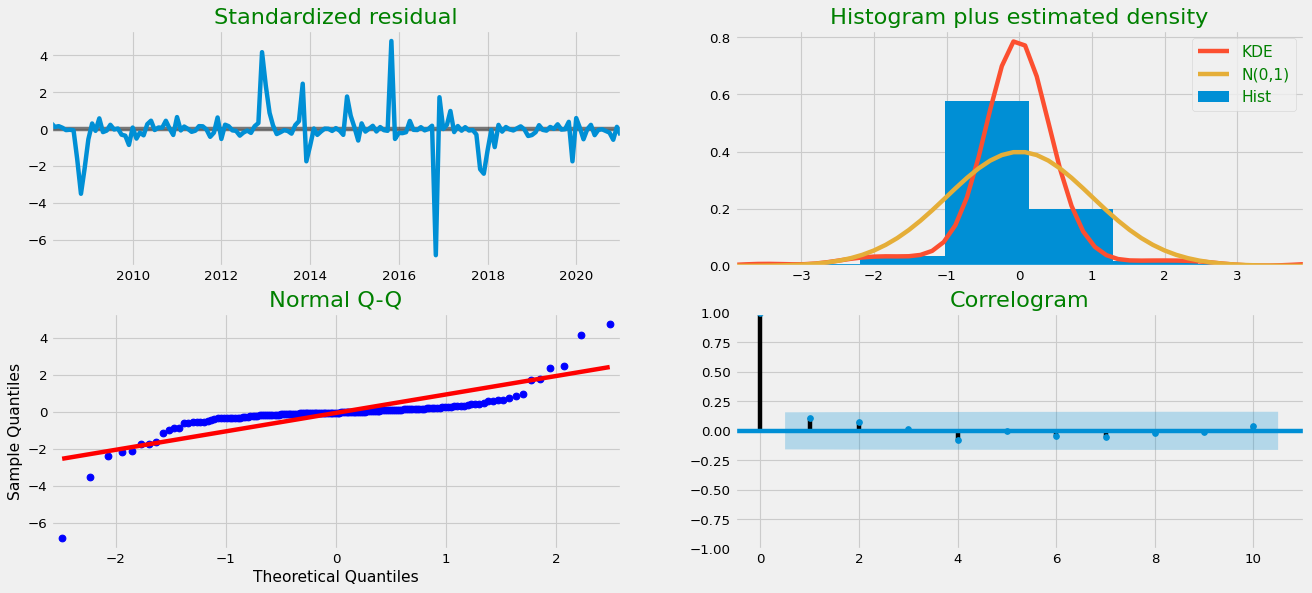

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

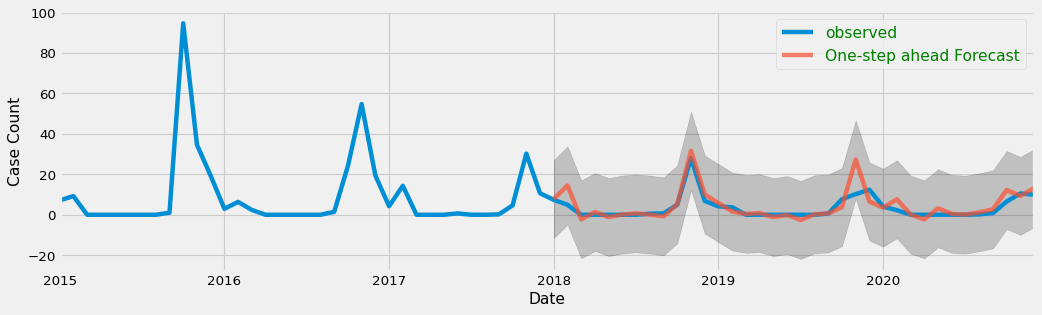

In [ ]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':80})
pred = results.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = endog2['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Case Count')
plt.legend()
plt.show()

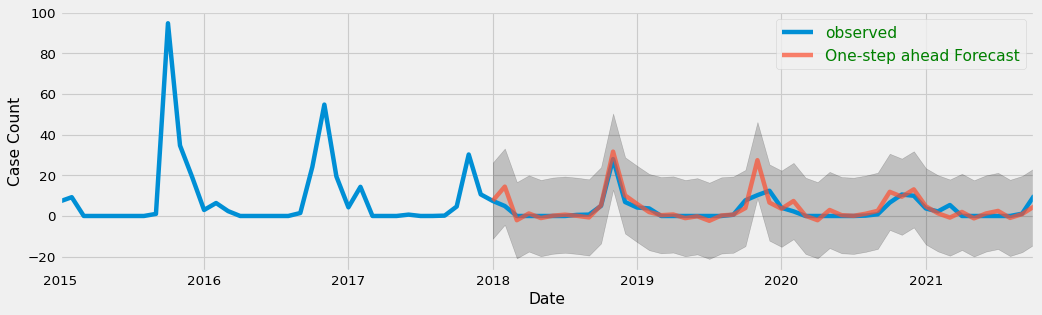

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = endog2['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Case Count')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = endog2['2018-01-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 14.06
The Root Mean Squared Error is 3.75


In [ ]:
y_forecasted = pred.predicted_mean
y_truth = endog2['2018-01-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 20.69
The Root Mean Squared Error is 4.55


In [ ]:
pred_uc = results.get_forecast(exog=exog2.loc['2018':],steps=24)
pred_ci = pred_uc.conf_int()
ax = endog2.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Case Count')
plt.legend()
plt.show()

ValueError: ignored

In [ ]:
temp = pd.read_csv('/content/drive/My Drive/DS4A/FutureTemp.csv',parse_dates=['date'], index_col='date')

In [ ]:
temp.head()

,0.5,1,1.5,2
date,,,,
2022-01-31,6.920874,7.020874,7.120874,7.220874
2022-02-28,9.959015,10.059015,10.159015,10.259015
2022-03-31,8.918966,9.018966,9.118966,9.218966
2022-04-30,11.811700,11.911700,12.011700,12.111700
2022-05-31,17.608966,17.708966,17.808966,17.908966


In [ ]:
exog_half = sm.add_constant(temp['0.5'])

In [ ]:
exog_half.head()

,const,0.5
date,,
2022-01-31,1.0,6.920874
2022-02-28,1.0,9.959015
2022-03-31,1.0,8.918966
2022-04-30,1.0,11.811700
2022-05-31,1.0,17.608966


In [ ]:
exog_test

,const,temp_mean_celsius
date,,
2020-01-31,1.0,6.820874
2020-02-29,1.0,9.859015
2020-03-31,1.0,8.818966
2020-04-30,1.0,11.711700
2020-05-31,1.0,17.508966
2020-06-30,1.0,20.194643
2020-07-31,1.0,22.617303
2020-08-31,1.0,25.003547
2020-09-30,1.0,22.860099


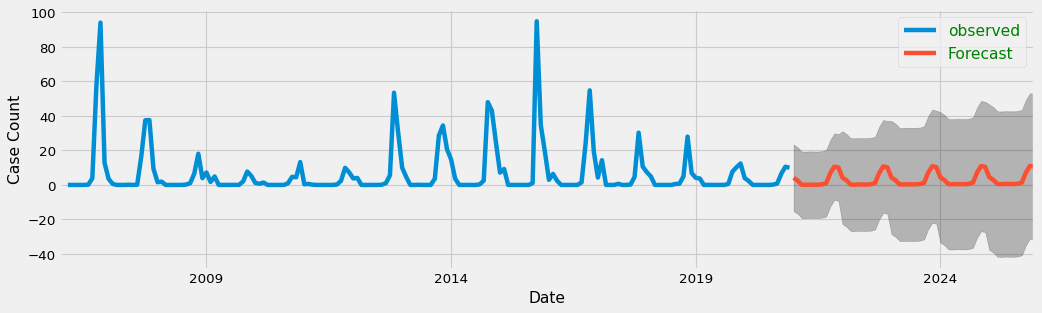

In [ ]:
pred_uc = results.get_forecast(exog=exog_half,steps=60)
pred_ci = pred_uc.conf_int()
ax = endog2.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Case Count')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_forecasted.head(60)

date
2018-01-31     7.803439
2018-02-28    14.463099
2018-03-31    -2.266233
2018-04-30     1.347740
2018-05-31    -1.112375
2018-06-30     0.119115
2018-07-31     0.705323
2018-08-31     0.093141
2018-09-30    -0.797042
2018-10-31     5.186540
2018-11-30    31.636988
2018-12-31    10.017489
2019-01-31     5.779193
2019-02-28     1.624987
2019-03-31     0.413539
2019-04-30     0.803914
2019-05-31    -1.145990
2019-06-30    -0.152652
2019-07-31    -2.566635
2019-08-31     0.248990
2019-09-30     0.662794
2019-10-31     3.803837
2019-11-30    27.375866
2019-12-31     6.543975
2020-01-31     3.496786
2020-02-29     7.658911
2020-03-31     0.091169
2020-04-30    -2.254197
2020-05-31     3.203769
2020-06-30     0.428277
2020-07-31     0.093341
2020-08-31     1.197435
2020-09-30     2.705617
2020-10-31    12.226888
2020-11-30     9.334347
2020-12-31    13.154871
Freq: M, dtype: float64

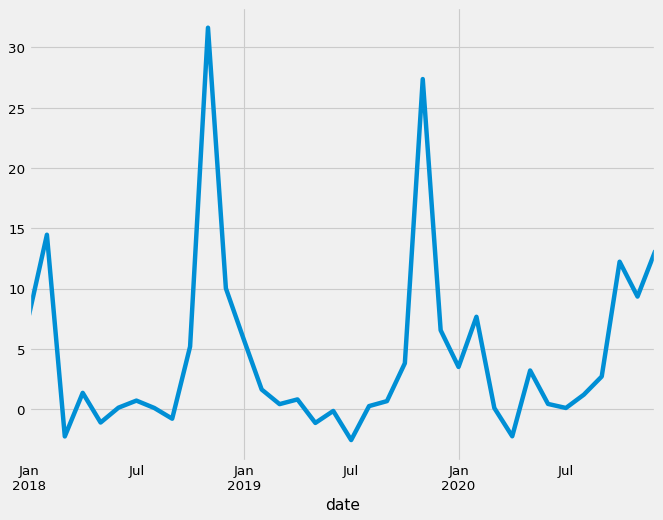

In [ ]:
y_forecasted.plot()

In [ ]:
y_truth.head(24)

date
2018-01-31     7.389207
2018-02-28     4.897392
2018-03-31     0.000000
2018-04-30     0.000000
2018-05-31     0.000000
2018-06-30     0.000000
2018-07-31     0.000000
2018-08-31     0.533672
2018-09-30     0.670406
2018-10-31     4.975948
2018-11-30    27.976431
2018-12-31     6.855786
2019-01-31     4.151012
2019-02-28     3.717936
2019-03-31     0.000000
2019-04-30     0.000000
2019-05-31     0.000000
2019-06-30     0.000000
2019-07-31     0.000000
2019-08-31     0.000000
2019-09-30     0.597700
2019-10-31     7.689052
2019-11-30    10.229997
2019-12-31    12.410025
Freq: M, Name: cases_per_100k, dtype: float64

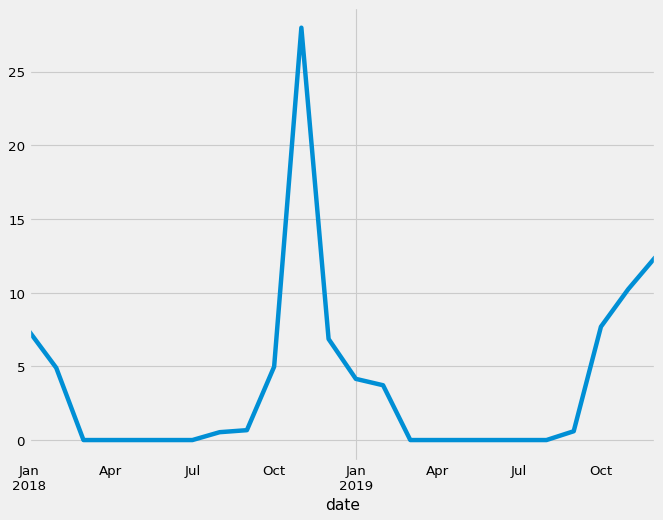

In [ ]:
y_truth.plot()

In [ ]:
pred_ci.head(24)

,lower cases_per_100k,upper cases_per_100k
2021-01-31,-15.153491,23.358321
2021-02-28,-16.735467,21.776345
2021-03-31,-19.151372,19.360440
2021-04-30,-19.217486,19.294327
2021-05-31,-19.063631,19.448181
2021-06-30,-19.141870,19.369943
2021-07-31,-19.151311,19.360501
2021-08-31,-18.944415,19.567398
2021-09-30,-18.270257,20.241555
2021-10-31,-12.435526,26.076287


In [ ]:
forecast = pred_uc.predicted_mean
forecast.head(24)

2021-01-31     4.102415
2021-02-28     2.520439
2021-03-31     0.104534
2021-04-30     0.038420
2021-05-31     0.192275
2021-06-30     0.114037
2021-07-31     0.104595
2021-08-31     0.311491
2021-09-30     0.985649
2021-10-31     6.820381
2021-11-30    10.615532
2021-12-31    10.122186
2022-01-31     4.204379
2022-02-28     2.622403
2022-03-31     0.206498
2022-04-30     0.140384
2022-05-31     0.294239
2022-06-30     0.216001
2022-07-31     0.206559
2022-08-31     0.413455
2022-09-30     1.087613
2022-10-31     6.922344
2022-11-30    10.717496
2022-12-31    10.224150
Freq: M, dtype: float64

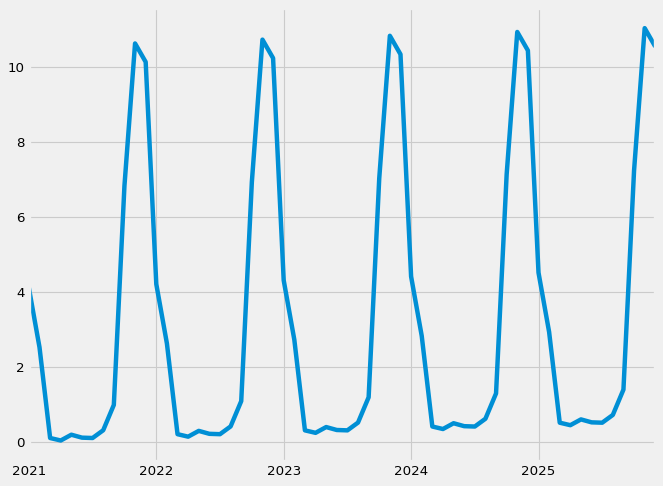

In [ ]:
forecast.plot()